# <center> Computational Intelligence Course </center>
## <center> Homework 3-1: Neural Network</center>
### <center>Authors: Sajede Nicknadaf, Hadis Ahamdian</center>

## حل مساله با استفاده از شبکه های عصبی
در این قسمت قصد داریم شبکه ی عصبی چندلایه ای طراحی کنیم که بتواند تصاویر را در هفت کلاس دسته بندی کند
کتابخانه های استفاده شده برای این بخش، در بلاک زیر قابل مشاهده است


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
%matplotlib inline

باز کردن و ذخیره ی داده های آموزش و ولیدیشن و تست

In [4]:
def load_data(file_name):
    npzfile = np.load(file_name)

    X_train = npzfile["inputs_train"].T / 255.0
    X_valid = npzfile["inputs_valid"].T / 255.0
    X_test = npzfile["inputs_test"].T / 255.0
    Y_train = npzfile["target_train"].tolist()
    Y_valid = npzfile["target_valid"].tolist()
    Y_test = npzfile["target_test"].tolist()

    num_class = max(Y_train + Y_valid + Y_test) + 1
    Y_train_1hot = np.zeros([num_class, len(Y_train)])
    Y_valid_1hot = np.zeros([num_class, len(Y_valid)])
    Y_test_1hot = np.zeros([num_class, len(Y_test)])

    for ii, xx in enumerate(Y_train):
        Y_train_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(Y_valid):
        Y_valid_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(Y_test):
        Y_test_1hot[xx, ii] = 1.0

    
    return X_train.T, X_valid.T, X_test.T, Y_train_1hot.T, Y_valid_1hot.T, Y_test_1hot.T


In [5]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = load_data("data/toronto_face.npz")

[0. 0. 1. 0. 0. 0. 0.]
(419, 7)


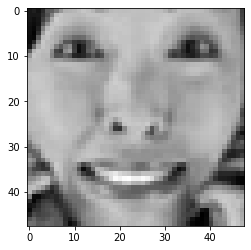

In [6]:
ix = 20;
print(Y_train[ix])
print(np.shape(Y_valid))
plt.figure(ix)
plt.imshow(X_train[ix].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

### کد های ما
در ابتدا توابعی که پیاده سازی شده است توضیح داده میشود


تابع زیر به منظور دسته بندی داده با سایز بَچ های مورد نظر است

In [7]:
def get_batch(x_data, y_data, batch_size):
    idxs = np.random.randint(0, len(y_data), batch_size)
    return x_data[idxs,:], y_data[idxs]

تابع زیر مقدار خطا را بر اساس مقدار پیش بینی شده محاسبه میکند. تابع خطایی که در نظر گرفته شده

cross enthropy

 می باشد و برای محاسبه ی آن از کتابخانه ها استفاده شده

In [8]:
def loss_fn(logits, labels):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))
    return cross_entropy

در دو بلاک زیر مقادیر زیر برای آموزش تعیین و مقداردهی شده اند 

optimizer, epoch number, batch size

هم چنین متغیرهایی برای ذخیره ی خطا در هرمرحله تعریف شده که در ادامه برای رسم نمودار از آن ها استفاده خواهد شد

In [9]:
# setup the optimizer
optimizer = tf.keras.optimizers.Adam()

In [10]:
# Python optimisation variables
epochs = 50
batch_size = 100
epoch_num=[]
train_errors=[]

### قسمت اول
 در این بخش یک شبکه ی عصبی 3 لایه طراحی میکنیم و عملکرد آن روی داده هارا مورد بررسی قرار میدهیم ابن شبکه به شکل یک تابع وزن ها و بایاس ها را دریافت میکند و مقادیر پیش بینی شده را با استفاده از کتابخوانه های موجود باز میگرداند

In [11]:
def nn_3_layer(x_input, W1, b1, W2, b2, W3, b3):
    # flatten the input image from 28 x 28 to 784
    x_input = tf.reshape(x_input, (x_input.shape[0], -1))
    x = tf.add(tf.matmul(tf.cast(x_input, tf.float32), W1), b1)
    x = tf.nn.relu(x)
    x2 =tf.add(tf.matmul(x, W2), b2)
    x2 = tf.nn.relu(x2)
    logits = tf.add(tf.matmul(x2, W3), b3)
    return logits

در این بخش وزن ها و بایاس هایی که قرار است در شبکه ی عصبی ای که تابع آن نوشته شده، استفاده شود مقدار دهی میشوند

In [12]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

تابع زیر که تابع آموزش است به تعداد دفعات تنظیم شده روی بَچ های داده های آموزش پیمایش میکند تا شبکه ی طراحی شده آموزش ببیند و در هر مرحله از پیمایش خطا روی داده های آموزش و هم چنین داده های ولیدیشن محاسبه و ذخیره میشود(با استفاده از توابعی که قبلا تعریف شدند) تا  برای تحلیل های بعدی مورد استفاده قرار بگیرد  

In [13]:
def train(print_flag):    
    total_batch = int(len(Y_train) / batch_size)
    epoch_num.clear()
    train_errors.clear()
    valid_errors.clear()

    epochs=50
    for epoch in range(epochs):
        total_loss = 0
        for i in range(total_batch):
            batch_x, batch_y = get_batch(X_train, Y_train, batch_size=batch_size)
            # create tensors
            batch_x = tf.Variable(batch_x)
            batch_y = tf.Variable(batch_y)
            with tf.GradientTape() as tape:
                logits = nn_3_layer(batch_x, W1, b1, W2, b2, W3, b3)
                loss = loss_fn(logits, batch_y)
            gradients = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])
            optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3]))
            total_loss += loss / total_batch

        epoch_num.append(epoch)
        train_errors.append(total_loss)
        test_logits = nn_3_layer(X_valid, W1, b1, W2, b2,W3,b3)
        valid_errors.append(loss_fn(test_logits,Y_valid))
        if(print_flag==1):
            print(f"Epoch: {epoch + 1}, loss={total_loss:.3f}")

    print("\nTraining complete!")

تابع آموزش صدا زده شده و به تعداد 50 مرحله پیمایش انجام میدهد. میتوان دید در هر مرحله مقدار خطا کاهش یافته است

In [14]:
epoch_num=[]
valid_errors=[]
train_errors=[]
train(1)

Epoch: 1, loss=2.577
Epoch: 2, loss=1.679
Epoch: 3, loss=1.439
Epoch: 4, loss=1.294
Epoch: 5, loss=1.222
Epoch: 6, loss=1.105
Epoch: 7, loss=1.069
Epoch: 8, loss=1.009
Epoch: 9, loss=1.000
Epoch: 10, loss=0.961
Epoch: 11, loss=0.983
Epoch: 12, loss=1.035
Epoch: 13, loss=0.894
Epoch: 14, loss=0.893
Epoch: 15, loss=0.847
Epoch: 16, loss=0.837
Epoch: 17, loss=0.782
Epoch: 18, loss=0.827
Epoch: 19, loss=0.792
Epoch: 20, loss=0.771
Epoch: 21, loss=0.754
Epoch: 22, loss=0.757
Epoch: 23, loss=0.748
Epoch: 24, loss=0.702
Epoch: 25, loss=0.711
Epoch: 26, loss=0.690
Epoch: 27, loss=0.672
Epoch: 28, loss=0.707
Epoch: 29, loss=0.685
Epoch: 30, loss=0.635
Epoch: 31, loss=0.582
Epoch: 32, loss=0.581
Epoch: 33, loss=0.567
Epoch: 34, loss=0.584
Epoch: 35, loss=0.542
Epoch: 36, loss=0.554
Epoch: 37, loss=0.653
Epoch: 38, loss=0.654
Epoch: 39, loss=0.549
Epoch: 40, loss=0.532
Epoch: 41, loss=0.499
Epoch: 42, loss=0.509
Epoch: 43, loss=0.523
Epoch: 44, loss=0.625
Epoch: 45, loss=0.518
Epoch: 46, loss=0.5

در این مرحله شبکه آموزش دیده و خطا به ازای هر مرحله پیمایش برای داده های ولیدیشن و داده های آموزش در نمودار زیر قابل مشاهده است. خطا روی هر دو دسته داده به ازای هر پیمایش کاهش یافته است. نمودار قرمز برای خطای داده های آموزش و نمودار آبی نماینده ی خطای داده های ولیدیشن در طول آموزش هستند میتوان دید که هردوتا خطا به طرز معقولی رو به کاهش هستند و در نهایت تفاوت مقداری زیادی ندارند پس به نظر نمیرسید مدل آندرفیت یا اورفیت شده باشد.

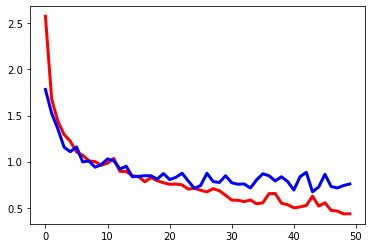

In [15]:
plt.plot(epoch_num,train_errors,color='red',linewidth=3) 
plt.plot(epoch_num,valid_errors,color='blue',linewidth=3) 

حال که مدل آموزش دیده است باید عملکرد آن روی داده های تست را بررسی کرد به این منظور از چهار معیار استفاده شده است و برای محاسبه ی آنها از کتابخانه ها استفاده شده. معیار ها :

f1 score, precision, recall, accuracy

accuracy:میتوان دید این مدل بیش از 70 درصد داده هارا به درستی دسته بندی کرده است و این  عملکرد خوبی است اما حال به سایر معیار ها دقت میکنیم

precision:این معیار برای مدل در حد قابل قبولی بالا بوده است یعنی اگر این مدل به ما بگوید عکسی متهلق به یکی از دسته هاست با اطمینان 72 درصد که اطمینان نسبتا خوبی است میتوان این پیش بینی را قبول کرد.

recall:اين معيار نسبت به معيار قبلي عملكرد ضعیف تری در مدل ما داشته است، این معیار بیانگر این است که مدل ما به طور متوسط  برای چند درصد از داده های هر دسته تشخیص داده که این داده مربوط به دسته ی درست است. میتوان دید مدل در این مورد عملکرد نسبتا قابل قبولی داشته و درصد تشخیص 68 درصد را داشته است

f1 score : با جمع بندی دو معیار بالا این معیار به دست می آید و میتوان دید که مدل ما جمعا عملكرد متوسط رو به خوبی داشته 

In [16]:
logs = nn_3_layer(X_test, W1, b1, W2, b2, W3, b3)
max_idxs = tf.argmax(logs, axis=1)
Y=tf.argmax(Y_test, axis=1)
print(f"F1_score: {f1_score(Y, max_idxs, average='macro')}")
print(f"Precision: {precision_score(Y, max_idxs, average='macro')}")
print(f"Recall: {recall_score(Y, max_idxs, average='macro')}")
print(f"Accuracy: {accuracy_score(Y, max_idxs)}")

F1_score: 0.6751981222918276
Precision: 0.7296095139737719
Recall: 0.6852777830452551
Accuracy: 0.7272727272727273


### قسمت دوم
#### تاثیر نرخ یادگیری
در این قسمت مقادیر مختلف نرخ یادگیری و سایز دسته ها و تاثیر آنها روی آموزش مورد بررسی قرار میگیرد

In [18]:
train_errors1=[]
train_errors2=[]
train_errors3=[]
train_errors4=[]
train_errors5=[]

ابتدا تاثیر **نرخ های یادگیری** مختلف روی آموزش را بررسی میکنیم.در این قسمت سایز بچ ها و سایر پارامترهای مربوط به مدل را ثابت نگه میداریم

نرخ یادگیری = 0.005

مدل با این نرخ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
train(0)
train_errors1=train_errors


نرخ یادگیری = 0.01

مدل با این نرخ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
train(0)
train_errors2=train_errors


Training complete!



نرخ یادگیری = 0.05

مدل با این نرخ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
train(0)
train_errors3=train_errors


Training complete!



نرخ یادگیری = 0.1

مدل با این نرخ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
train(0)
train_errors4=train_errors


Training complete!



نرخ یادگیری = 0.5

مدل با این نرخ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)

# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
train(0)
train_errors5=train_errors


Training complete!


حال مقادیر خطای هر کدام از آموزش ها با نرخ های یادگیری متفاوت را بر حسب تعداد پیمایش رسم میکنیم همانطور که دیده میشود طیف تغییرات خطا در مدل ها بسیار متفاوت است به طور کلی از روی نمودار زیر میتوان گفت هرچه نرخ یادگیری کمتر باشد یادگیری با دقت بیشتری انجام شده و با قدم های آهسته تر به سمت بهترین جواب حرکت کرده و در نهایت به دقت بیشتری رسیده اما وقت نرخ یادگیری بزرگ بوده این قدم های بزرگ باعث شده در یک آستانه ای از اوپتیما گیر کن و در یک حدی از دقت متوقف شود

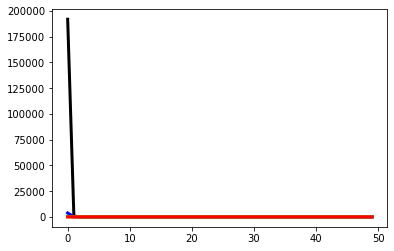

In [24]:
plt.plot(epoch_num,train_errors5,color='black',linewidth=3) 
plt.plot(epoch_num,train_errors4,color='blue',linewidth=3) 
plt.plot(epoch_num,train_errors3,color='green',linewidth=3) 
plt.plot(epoch_num,train_errors2,color='orange',linewidth=3) 
plt.plot(epoch_num,train_errors1,color='red',linewidth=3) 

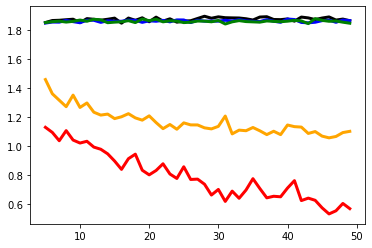

In [25]:
plt.plot(epoch_num[5:],train_errors5[5:],color='black',linewidth=3) 
plt.plot(epoch_num[5:],train_errors4[5:],color='blue',linewidth=3) 
plt.plot(epoch_num[5:],train_errors3[5:],color='green',linewidth=3) 
plt.plot(epoch_num[5:],train_errors2[5:],color='orange',linewidth=3) 
plt.plot(epoch_num[5:],train_errors1[5:],color='red',linewidth=3) 

#### تغییر اندازه بچ

اینجا تاثیر **اندازه ی بچ** های مختلف روی آموزش را بررسی میکنیم.در این قسمت نرخ یادگیری  و سایر پارامترهای مربوط به مدل را ثابت نگه میداریم

اندازه بچ = 10

مدل با این اندازه بچ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [26]:
optimizer = tf.keras.optimizers.Adam()

train_errors1=[]
train_errors2=[]
train_errors3=[]
train_errors4=[]
train_errors5=[]

In [27]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
batch_size = 10
train(0)
train_errors1=train_errors


Training complete!



اندازه بچ = 50

مدل با این اندازه بچ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [28]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
batch_size = 50
train(0)
train_errors2=train_errors


Training complete!



اندازه بچ = 100

مدل با این اندازه بچ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [29]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
batch_size = 100
train(0)
train_errors3=train_errors


Training complete!



اندازه بچ = 500

مدل با این اندازه بچ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [30]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
batch_size = 500
train(0)
train_errors4=train_errors


Training complete!



اندازه بچ = 1000

مدل با این اندازه بچ آموزش داده شده و مقادیر آن جهت رسم نمودار و تحلیل های بعدی ذخیره میشود

In [31]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1000, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
batch_size = 1000
train(0)
train_errors5=train_errors


Training complete!


حال مقادیر خطای هر کدام از آموزش ها با اندازه بج های متفاوت را بر حسب تعداد پیمایش رسم میکنیم همانطور که دیده میشود میتوان گفت هرچه سایز بچ کمتر باشد شبکه به طور قابل توجهی بهتر آموزش میبینید و در نهایت خطای کمتری خواهد داشت. البته باید به این نکته اشاره کنیم که هرچه سایز بچ کوچک تر باشد یادگیری زمان بیشتری میبرد. برای درک بهتر از چگونگی عملکرد هر اندازه بچ در قسمت بعدی اندکی روی نمودار بزرگنمایی انجام داده و دقیق تر میبینیم.

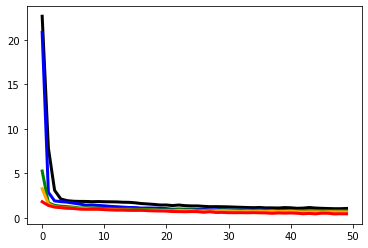

In [32]:
plt.plot(epoch_num,train_errors5,color='black',linewidth=3) 
plt.plot(epoch_num,train_errors4,color='blue',linewidth=3) 
plt.plot(epoch_num,train_errors3,color='green',linewidth=3) 
plt.plot(epoch_num,train_errors2,color='orange',linewidth=3) 
plt.plot(epoch_num,train_errors1,color='red',linewidth=3) 

نمودار بزرگنمایی شده
قرمز:10
نارنجی:50
سبز:100
آبی:500
مشکی:1000

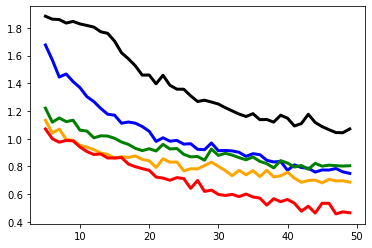

In [33]:
plt.plot(epoch_num[5:],train_errors5[5:],color='black',linewidth=3) 
plt.plot(epoch_num[5:],train_errors4[5:],color='blue',linewidth=3) 
plt.plot(epoch_num[5:],train_errors3[5:],color='green',linewidth=3) 
plt.plot(epoch_num[5:],train_errors2[5:],color='orange',linewidth=3) 
plt.plot(epoch_num[5:],train_errors1[5:],color='red',linewidth=3) 

### قسمت سوم
#### تاثیر شبکه های مختلف

اینجا سه مدل که دوتاش سه لایه و یکیش ۴ لایه هست تعریف میکنیم و آموزش میدیم و تست میکنیم و بین آن ها مقایسه انجام میدهیم
در هر مدل چهار معیار زیر محاسبه و ذخیره میشود تا بین آنها مقایسه انجام شود :

accuracy, precision, recall, f1 score

In [34]:
epoch_num=[]
valid_errors=[]
train_errors=[]
batch_size = 100

train_errors1=[]
train_errors2=[]
train_errors3=[]

مدل اول: سه لایه با تعداد نرون کم

In [35]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([500, 50], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([50]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([50, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
train(0)
train_errors1=train_errors


Training complete!



accuracy:میتوان دید این مدل بیش از 60 درصد داده هارا به درستی دسته بندی کرده است و این  عملکرد متوسطی است اما حال به سایر معیار ها دقت میکنیم

precision:این معیار برای مدل خیلی خوب نبوده یعنی اگر این مدل به ما بگوید عکسی متعلق به یکی از دسته هاست با اطمینان 58 درصد که اطمینان خوبی نیست  میتوان این پیش بینی را قبول کرد.

recall: این معیار بیانگر این است که مدل ما به طور متوسط  برای چند درصد از داده های هر دسته تشخیص داده که این داده مربوط به دسته ی درست است. میتوان دید مدل در این مورد عملکرد عادی ای داشته و درصد تشخیص 58 درصد را داشته است

f1 score : با جمع بندی دو معیار بالا این معیار به دست می آید و میتوان دید که مدل ما جمعا عملكرد خیلی عادی ای داشته و خیلی خوب نبوده 

In [36]:
logs = nn_3_layer(X_test, W1, b1, W2, b2, W3, b3)
max_idxs = tf.argmax(logs, axis=1)
Y=tf.argmax(Y_test, axis=1)
print(f"F1_score: {f1_score(Y, max_idxs, average='macro')}")
print(f"Precision: {precision_score(Y, max_idxs, average='macro')}")
print(f"Recall: {recall_score(Y, max_idxs, average='macro')}")
print(f"Accuracy: {accuracy_score(Y, max_idxs)}")

F1_score: 0.5528974746753451
Precision: 0.5790396920331131
Recall: 0.5857104673553752
Accuracy: 0.6493506493506493


مدل دوم :سه لایه با تعداد نرون زیاد

In [37]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 2000], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([2000]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([2000, 1500], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1500]), name='b2')
# and the weights connecting the hidden layer1 to the output layer
W3 = tf.Variable(tf.random.normal([1500, 7], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([7]), name='b3')

epoch_num=[]
valid_errors=[]
train_errors=[]
train(0)
train_errors2=train_errors


Training complete!



accuracy:میتوان دید این مدل بیش از 70 درصد داده هارا به درستی دسته بندی کرده است و این  عملکرد خوبی است اما حال به سایر معیار ها دقت میکنیم

precision:این معیار برای مدل در حد متوسطی بوده است یعنی اگر این مدل به ما بگوید عکسی متهلق به یکی از دسته هاست با اطمینان 66 درصد که اطمینان نسبتا خوبی است میتوان این پیش بینی را قبول کرد.

recall:این معیار بیانگر این است که مدل ما به طور متوسط  برای چند درصد از داده های هر دسته تشخیص داده که این داده مربوط به دسته ی درست است. میتوان دید مدل در این مورد عملکرد متوسطی داشته و درصد تشخیص 65 درصد را داشته است

f1 score : با جمع بندی دو معیار بالا این معیار به دست می آید و میتوان دید که مدل ما جمعا عملكرد متوسط رو به خوبی داشته و از مدل قبلی بهتر بوده است

In [38]:
logs = nn_3_layer(X_test, W1, b1, W2, b2, W3, b3)
max_idxs = tf.argmax(logs, axis=1)
Y=tf.argmax(Y_test, axis=1)
print(f"F1_score: {f1_score(Y, max_idxs, average='macro')}")
print(f"Precision: {precision_score(Y, max_idxs, average='macro')}")
print(f"Recall: {recall_score(Y, max_idxs, average='macro')}")
print(f"Accuracy: {accuracy_score(Y, max_idxs)}")

F1_score: 0.6523461723184122
Precision: 0.6694717786753012
Recall: 0.6529166071184791
Accuracy: 0.7012987012987013


مدل سوم : چهار لایه

In [39]:
def nn_4_layer(x_input, W1, b1, W2, b2, W3, b3,W4,b4):
    # flatten the input image from 28 x 28 to 784
    x_input = tf.reshape(x_input, (x_input.shape[0], -1))
    x = tf.add(tf.matmul(tf.cast(x_input, tf.float32), W1), b1)
    x = tf.nn.relu(x)
    x2 =tf.add(tf.matmul(x, W2), b2)
    x2 = tf.nn.relu(x2)
    x3 =tf.add(tf.matmul(x2, W3), b3)
    x3 = tf.nn.relu(x3)
    logits = tf.add(tf.matmul(x3, W4), b4)
    return logits

In [40]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer2 to the hidden layer3
W3 = tf.Variable(tf.random.normal([1000, 500], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([500]), name='b3')
# and the weights connecting the hidden layer3 to the output layer
W4 = tf.Variable(tf.random.normal([500, 7], stddev=0.03), name='W4')
b4 = tf.Variable(tf.random.normal([7]), name='b4')

In [41]:
total_batch = int(len(Y_train) / batch_size)
epoch_num.clear()
epochs=50
for epoch in range(epochs):
    total_loss = 0
    for i in range(total_batch):
        batch_x, batch_y = get_batch(X_train, Y_train, batch_size=batch_size)
        # create tensors
        batch_x = tf.Variable(batch_x)
        batch_y = tf.Variable(batch_y)
        with tf.GradientTape() as tape:
            logits = nn_4_layer(batch_x, W1, b1, W2, b2, W3, b3,W4,b4)
            loss = loss_fn(logits, batch_y)
        gradients = tape.gradient(loss, [W1, b1, W2, b2, W3, b3,W4,b4])
        optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3,W4,b4]))
        total_loss += loss / total_batch
        
    epoch_num.append(epoch)
    train_errors3.append(total_loss)
    
    print(f"Epoch: {epoch + 1}, loss={total_loss:.3f}")
    
print("\nTraining complete!")


Epoch: 1, loss=3.182
Epoch: 2, loss=1.829
Epoch: 3, loss=1.694
Epoch: 4, loss=1.436
Epoch: 5, loss=1.319
Epoch: 6, loss=1.251
Epoch: 7, loss=1.125
Epoch: 8, loss=1.117
Epoch: 9, loss=1.088
Epoch: 10, loss=1.030
Epoch: 11, loss=1.022
Epoch: 12, loss=1.049
Epoch: 13, loss=1.038
Epoch: 14, loss=0.948
Epoch: 15, loss=0.969
Epoch: 16, loss=0.905
Epoch: 17, loss=0.892
Epoch: 18, loss=0.915
Epoch: 19, loss=0.895
Epoch: 20, loss=0.851
Epoch: 21, loss=0.859
Epoch: 22, loss=0.848
Epoch: 23, loss=0.847
Epoch: 24, loss=0.840
Epoch: 25, loss=0.822
Epoch: 26, loss=0.823
Epoch: 27, loss=0.786
Epoch: 28, loss=0.768
Epoch: 29, loss=0.777
Epoch: 30, loss=0.801
Epoch: 31, loss=0.794
Epoch: 32, loss=0.715
Epoch: 33, loss=0.765
Epoch: 34, loss=0.752
Epoch: 35, loss=0.714
Epoch: 36, loss=0.697
Epoch: 37, loss=0.707
Epoch: 38, loss=0.696
Epoch: 39, loss=0.743
Epoch: 40, loss=0.666
Epoch: 41, loss=0.642
Epoch: 42, loss=0.624
Epoch: 43, loss=0.626
Epoch: 44, loss=0.676
Epoch: 45, loss=0.698
Epoch: 46, loss=0.6


accuracy:میتوان دید این مدل بیش از 70 درصد داده هارا به درستی دسته بندی کرده است و این  عملکرد خوبی است اما حال به سایر معیار ها دقت میکنیم

precision:این معیار برای مدل در حد قابل قبولی بالا بوده است یعنی اگر این مدل به ما بگوید عکسی متهلق به یکی از دسته هاست با اطمینان 64 درصد که اطمینان نسبتا خوبی است میتوان این پیش بینی را قبول کرد.

recall:اين معيار نسبت به معيار قبلي عملكرد ضعیف تری در مدل ما داشته است، این معیار بیانگر این است که مدل ما به طور متوسط  برای چند درصد از داده های هر دسته تشخیص داده که این داده مربوط به دسته ی درست است. میتوان دید مدل در این مورد عملکرد نسبتا قابل قبولی داشته و درصد تشخیص 66 درصد را داشته است

f1 score :  با جمع بندی دو معیار بالا این معیار به دست می آید و میتوان دید که مدل ما جمعا عملكرد متوسط رو به خوبی داشته و با اینکه درصد بیشتری از داده هارادرست دسته بندی کرده این معیار برای او کمتر از مدل قبلی شده است. محتمل است که مدل دچار اورفیت شده باشد

In [42]:
logs = nn_4_layer(X_test, W1, b1, W2, b2, W3, b3,W4,b4)
max_idxs = tf.argmax(logs, axis=1)
Y=tf.argmax(Y_test, axis=1)
print(f"F1_score: {f1_score(Y, max_idxs, average='macro')}")
print(f"Precision: {precision_score(Y, max_idxs, average='macro')}")
print(f"Recall: {recall_score(Y, max_idxs, average='macro')}")
print(f"Accuracy: {accuracy_score(Y, max_idxs)}")

F1_score: 0.6468857439321997
Precision: 0.6482739304357669
Recall: 0.6639509706046249
Accuracy: 0.7012987012987013


مقایسه کارایی:
    در کل با توجه به نتایج بدست آمده به این نتیجه میرسیم هر چه تعداد نرون های لایه و تعداد لایه ها بیشتر باشد نتیجه بهتری بگیریم البته به شرط آن که مدل اورفیت نشود.

مقایسه همگرایی :

در قسمت های قبل در طی آموزش دادن تمام شبکه ها مقدا خطای آنها به ازای هر پیمایش ذخیره شده است و اینجا در نموداری قابل مشاهده است.میتوان دید مدل با تعداد لایه و نرون کم همگرایی کمتری دارد و دلیل این امر این است که مدل به اندازه ی کافی پیچیده تیست  و نسبت به مدل های دیگر آندرفیت تر است

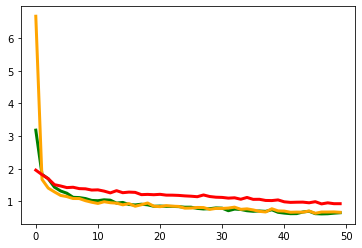

In [43]:
plt.plot(epoch_num,train_errors3,color='green',linewidth=3) 
plt.plot(epoch_num,train_errors2,color='orange',linewidth=3) 
plt.plot(epoch_num,train_errors1,color='red',linewidth=3) 

نمودار فوق از نمای نزدیک تر 
قرمز:سه لایه با تعداد نرون کم
نارنجی:سه لایه با تعداد نرون زیاد
سبز:چهار لایه

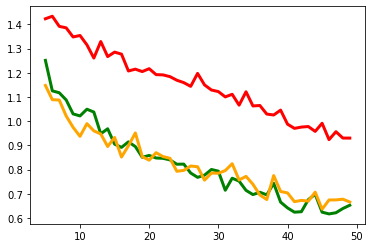

In [44]:
plt.plot(epoch_num[5:],train_errors3[5:],color='green',linewidth=3) 
plt.plot(epoch_num[5:],train_errors2[5:],color='orange',linewidth=3) 
plt.plot(epoch_num[5:],train_errors1[5:],color='red',linewidth=3) 

### قسمت د

در قطعه کد زیر تعداد عکس هایی که اشتباه دسته بندی شده اند و کلاسی که باید به آن تعلق داشته باشند نمایش داده شده است.
مشکل میتواند از ساده بودن شبکه ی عصبی باشد پس شبکه ی پیچیده تری برای این مساله طراحی میکنیم

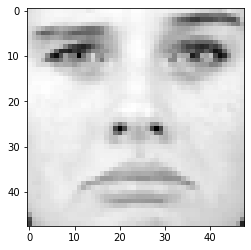

correct class is 4 but predict is 6


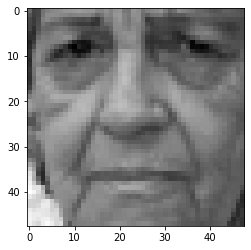

correct class is 0 but predict is 4


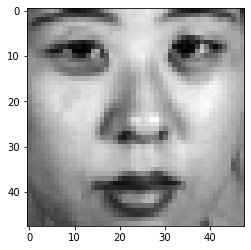

correct class is 1 but predict is 5


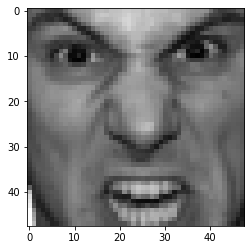

correct class is 0 but predict is 3


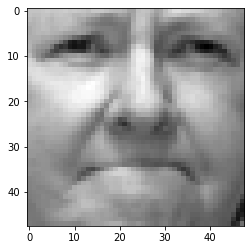

correct class is 0 but predict is 3


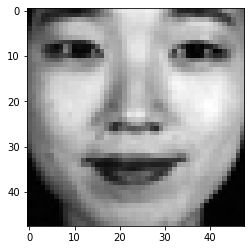

correct class is 3 but predict is 6


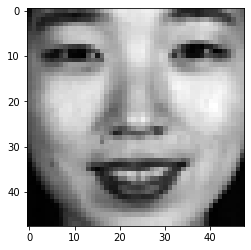

correct class is 3 but predict is 1


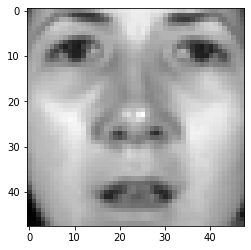

correct class is 5 but predict is 4


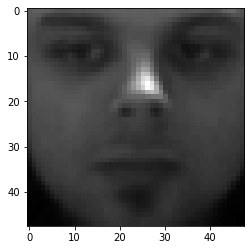

correct class is 6 but predict is 2


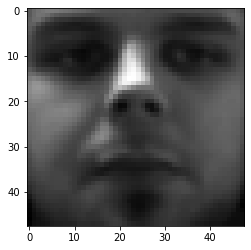

correct class is 6 but predict is 2
number of images with this property : 10


In [45]:
count=0
for i in range(len(Y)):
    if(logs[i][Y[i]]<0.5):
        count+=1
        plt.figure(i)
        plt.imshow(X_test[i].reshape((48, 48)), interpolation='none', cmap='gray')
        plt.show()
        print(f"correct class is {Y[i]} but predict is {(max_idxs[i])}")
print(f"number of images with this property : {count}")

تست ۵ لایه :

دراین قسمت یک شبکه ی پیچیده تر با پنج لایه نرون طراحی و آموزش داده شده 

In [46]:
def nn_5_layer(x_input, W1, b1, W2, b2, W3, b3,W4,b4,W5,b5):
    # flatten the input image from 28 x 28 to 784
    x_input = tf.reshape(x_input, (x_input.shape[0], -1))
    x = tf.add(tf.matmul(tf.cast(x_input, tf.float32), W1), b1)
    x = tf.nn.relu(x)
    x2 =tf.add(tf.matmul(x, W2), b2)
    x2 = tf.nn.relu(x2)
    x3 =tf.add(tf.matmul(x2, W3), b3)
    x3 = tf.nn.relu(x3)
    x4 =tf.add(tf.matmul(x3, W4), b4)
    x4 = tf.nn.relu(x4)
    logits = tf.add(tf.matmul(x4, W5), b5)
    return logits

In [47]:
# now declare the weights connecting the input to the hidden layer1
W1 = tf.Variable(tf.random.normal([2304, 1500], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random.normal([1500]), name='b1')
# and the weights connecting the hidden layer1 to the hidden layer2
W2 = tf.Variable(tf.random.normal([1500, 1000], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random.normal([1000]), name='b2')
# and the weights connecting the hidden layer2 to the hidden layer3
W3 = tf.Variable(tf.random.normal([1000, 500], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random.normal([500]), name='b3')
# and the weights connecting the hidden layer2 to the hidden layer3
W4 = tf.Variable(tf.random.normal([500, 200], stddev=0.03), name='W4')
b4 = tf.Variable(tf.random.normal([200]), name='b4')
# and the weights connecting the hidden layer3 to the output layer
W5 = tf.Variable(tf.random.normal([200, 7], stddev=0.03), name='W5')
b5 = tf.Variable(tf.random.normal([7]), name='b5')

In [48]:
epoch_num=[]
valid_errors=[]
train_errors=[]
batch_size = 100
train_errors4=[]

total_batch = int(len(Y_train) / batch_size)
epoch_num.clear()
epochs=50
for epoch in range(epochs):
    total_loss = 0
    for i in range(total_batch):
        batch_x, batch_y = get_batch(X_train, Y_train, batch_size=batch_size)
        # create tensors
        batch_x = tf.Variable(batch_x)
        batch_y = tf.Variable(batch_y)
        with tf.GradientTape() as tape:
            logits = nn_5_layer(batch_x, W1, b1, W2, b2, W3, b3,W4,b4,W5,b5)
            loss = loss_fn(logits, batch_y)
        gradients = tape.gradient(loss, [W1, b1, W2, b2, W3, b3,W4,b4,W5,b5])
        optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3,W4,b4,W5,b5]))
        total_loss += loss / total_batch
        
    epoch_num.append(epoch)
    train_errors4.append(total_loss)
    
    print(f"Epoch: {epoch + 1}, loss={total_loss:.3f}")
    
print("\nTraining complete!")


Epoch: 1, loss=2.169
Epoch: 2, loss=1.832
Epoch: 3, loss=1.745
Epoch: 4, loss=1.622
Epoch: 5, loss=1.413
Epoch: 6, loss=1.290
Epoch: 7, loss=1.255
Epoch: 8, loss=1.266
Epoch: 9, loss=1.175
Epoch: 10, loss=1.141
Epoch: 11, loss=1.128
Epoch: 12, loss=1.111
Epoch: 13, loss=1.054
Epoch: 14, loss=1.064
Epoch: 15, loss=1.027
Epoch: 16, loss=1.040
Epoch: 17, loss=0.979
Epoch: 18, loss=0.958
Epoch: 19, loss=0.960
Epoch: 20, loss=0.958
Epoch: 21, loss=0.976
Epoch: 22, loss=0.973
Epoch: 23, loss=0.855
Epoch: 24, loss=0.868
Epoch: 25, loss=0.898
Epoch: 26, loss=0.832
Epoch: 27, loss=0.888
Epoch: 28, loss=0.861
Epoch: 29, loss=0.804
Epoch: 30, loss=0.795
Epoch: 31, loss=0.814
Epoch: 32, loss=0.765
Epoch: 33, loss=0.764
Epoch: 34, loss=0.761
Epoch: 35, loss=0.790
Epoch: 36, loss=0.780
Epoch: 37, loss=0.711
Epoch: 38, loss=0.708
Epoch: 39, loss=0.761
Epoch: 40, loss=0.695
Epoch: 41, loss=0.693
Epoch: 42, loss=0.655
Epoch: 43, loss=0.718
Epoch: 44, loss=0.655
Epoch: 45, loss=0.668
Epoch: 46, loss=0.6

In [49]:
logs = nn_5_layer(X_test, W1, b1, W2, b2, W3, b3,W4,b4,W5,b5)
max_idxs = (tf.argmax(logs, axis=1))
Y=tf.argmax(Y_test, axis=1)
print(f"F1_score: {f1_score(Y, max_idxs, average='macro')}")
print(f"Precision: {precision_score(Y, max_idxs, average='macro')}")
print(f"Recall: {recall_score(Y, max_idxs, average='macro')}")
print(f"Accuracy: {accuracy_score(Y, max_idxs)}")

F1_score: 0.6436915605467995
Precision: 0.665124112423234
Recall: 0.65161233029441
Accuracy: 0.6987012987012987


نکته یقابل توجه که اینجا پیش می آید این است که عملکرد این شبکه نسبت به شبکه ی ساده تر قبلی بدتر بود و دلیل آن احتمالا این است که شبکه اورفیت شده است، پس مشکل به طور کلی از ساده بودن شبکه نبوده است، طی تحقیقات و بررسی ها در مورد این ست داده ها به این نتیجه رسیدیم که برای چالشی تر شدن آموزش، این داده ها اصولا با مقداری داده ی غلط همراه هستند یعنی لیبل بعضی از عکس ها میتواند ازابتدا اشتباه باشد و این موجب بخشی از خطای نهایی شده باشد. راه حل ممکن برای این موضوع یک پیش پردازش روی داده های آموزشی برای اصلاح داده های غلط است. هم چنین احتمال دیگری که وجود دارد این است که عدم یکنواخت بودن داده ها موجب کاهش عملکرد خوب شبکه میشود یعنی داده مثلا اندازه ی کلاس های متفاوت برابر نیست که برطرف کردن این مشکل لازم به راهکار های پیچیده تری دارد مانند تولید داده از روی داده های موجود برای یکنواخت کردن داده ها و یا تنطیم ضریب برای خطای هر دسته وابسته به اندازه ی آن دسته.

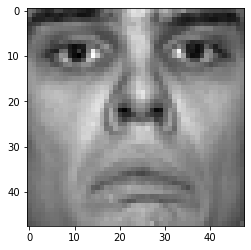

correct class is 4 but predict is 6


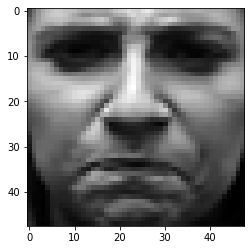

correct class is 0 but predict is 4


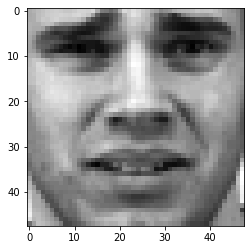

correct class is 2 but predict is 1


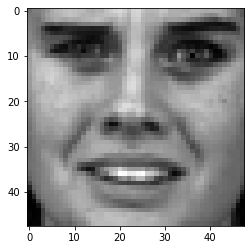

correct class is 2 but predict is 3


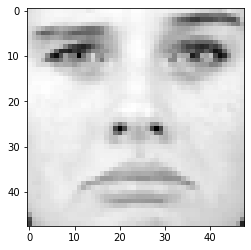

correct class is 4 but predict is 6


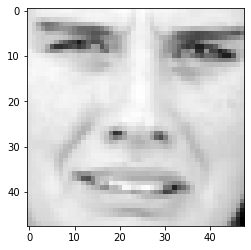

correct class is 1 but predict is 1


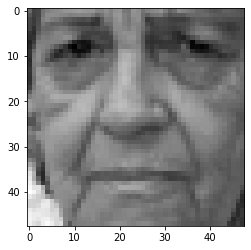

correct class is 0 but predict is 6


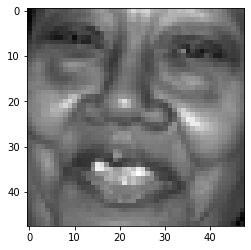

correct class is 3 but predict is 5


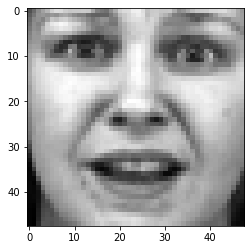

correct class is 2 but predict is 1


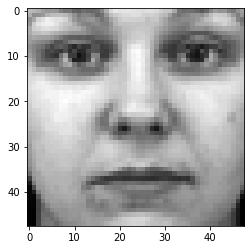

correct class is 6 but predict is 5


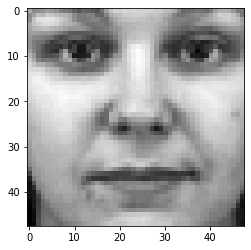

correct class is 6 but predict is 2


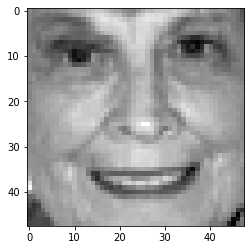

correct class is 3 but predict is 6


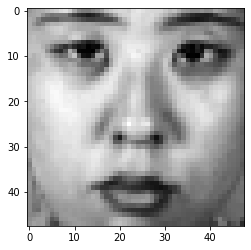

correct class is 0 but predict is 4


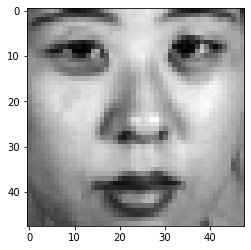

correct class is 1 but predict is 5


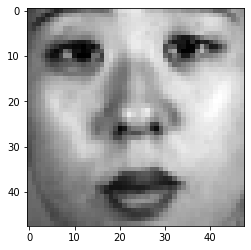

correct class is 4 but predict is 5


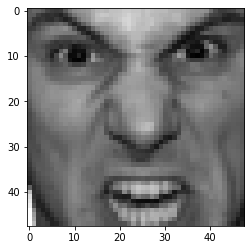

correct class is 0 but predict is 5


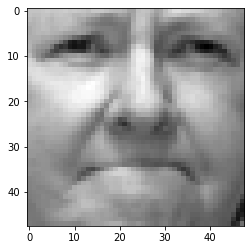

correct class is 0 but predict is 1


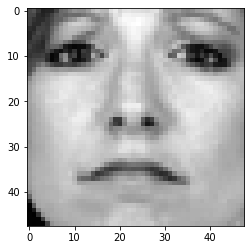

correct class is 4 but predict is 6


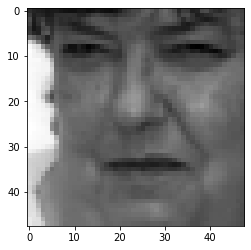

correct class is 1 but predict is 4


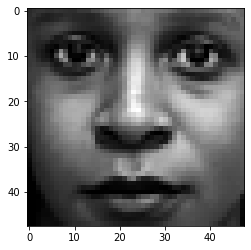

correct class is 6 but predict is 5


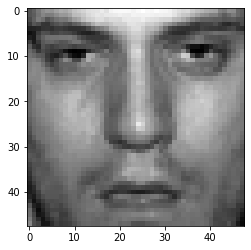

correct class is 6 but predict is 1


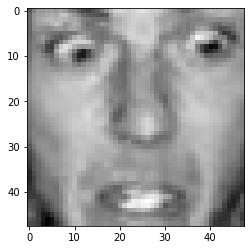

correct class is 2 but predict is 6


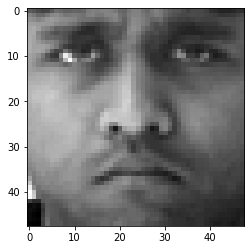

correct class is 0 but predict is 4


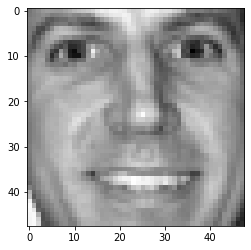

correct class is 3 but predict is 6


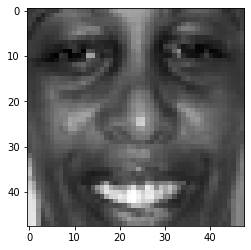

correct class is 3 but predict is 6


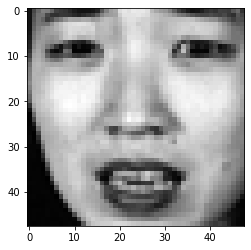

correct class is 2 but predict is 4


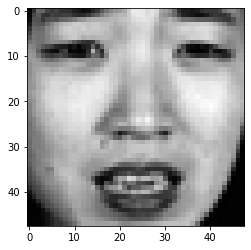

correct class is 2 but predict is 1


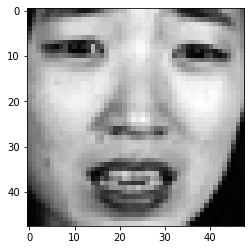

correct class is 2 but predict is 1


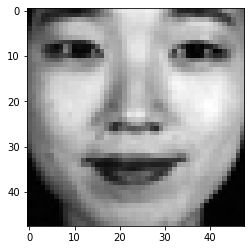

correct class is 3 but predict is 6


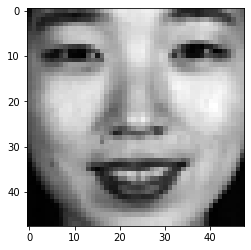

correct class is 3 but predict is 6


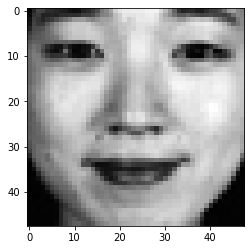

correct class is 3 but predict is 6


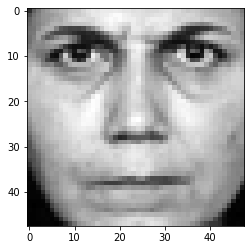

correct class is 0 but predict is 6


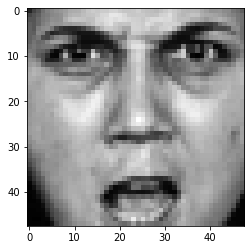

correct class is 0 but predict is 2


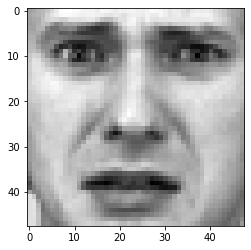

correct class is 2 but predict is 1


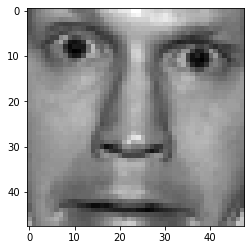

correct class is 2 but predict is 6


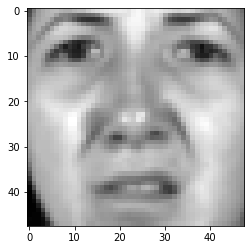

correct class is 1 but predict is 4


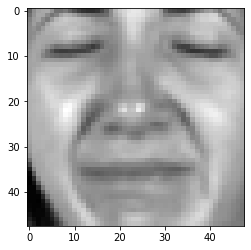

correct class is 4 but predict is 1


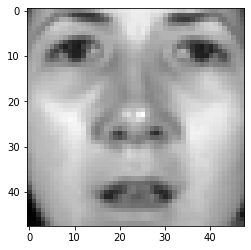

correct class is 5 but predict is 6


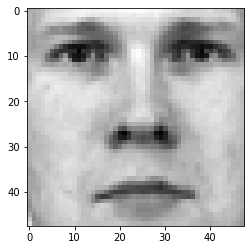

correct class is 6 but predict is 4


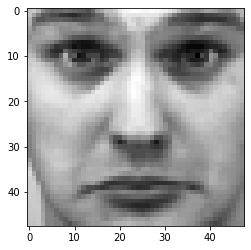

correct class is 4 but predict is 2


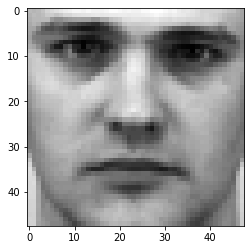

correct class is 6 but predict is 0


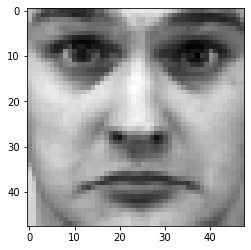

correct class is 4 but predict is 5


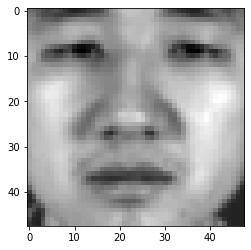

correct class is 6 but predict is 1


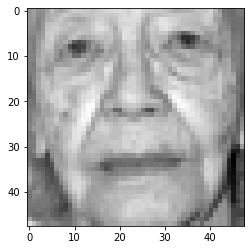

correct class is 6 but predict is 0


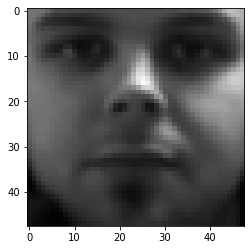

correct class is 6 but predict is 2


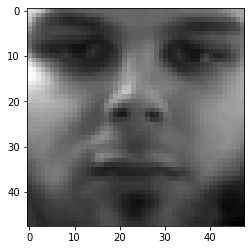

correct class is 6 but predict is 2


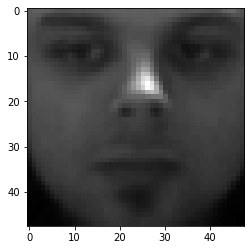

correct class is 6 but predict is 1


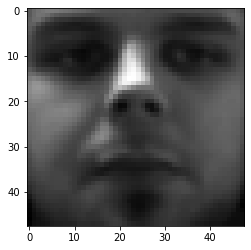

correct class is 6 but predict is 5


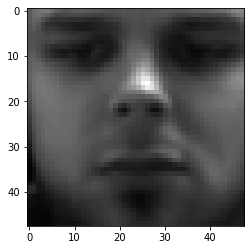

correct class is 6 but predict is 4


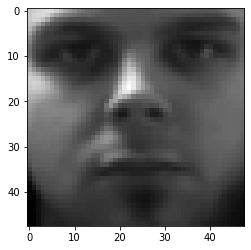

correct class is 6 but predict is 2
number of images with this property : 50


In [50]:
count=0
for i in range(len(Y)):
    if(logs[i][Y[i]]<0.5):
        count+=1
        plt.figure(i)
        plt.imshow(X_test[i].reshape((48, 48)), interpolation='none', cmap='gray')
        plt.show()
        print(f"correct class is {Y[i]} but predict is {(max_idxs[i])}")
print(f"number of images with this property : {count}")

در کل به نظر میرسد با این مدل ها نمیتوان به دقت بهتری رسید و بهتر است از شبکه های عصبی کانولوشنی استفاده کنیم